In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Reading our DB
df = pd.read_csv('./kaggle_survey_2020_responses.csv')
# Remove 1st Row which contain Column description and drop old Index to avoid being added as New Column
df_mod = df.iloc[1:].reset_index(drop=True)
df_mod.head(10)
# Create DataFrame for Descriptions to be refrence for Us
df_desc = df.iloc[0]

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df_mod.head(10)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,401,30-34,Man,India,Bachelor’s degree,Data Analyst,< 1 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,748,22-24,Man,Brazil,Bachelor’s degree,Student,3-5 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,171196,25-29,Woman,China,Master’s degree,Student,< 1 years,NaN,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,150,22-24,Man,China,No formal education past high school,Student,< 1 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Let's Define Some Helpful Functions for Our Work

In [4]:
def Insert_Count_per_Raw(DataFra,Col_name,NewCol):
    ''''
    Input:
        *Pandas Dataframe
        * Col_name: Splitted Column Tag need to be countted
        * New Column Name
    OutPut:
        * New Col which contain Count of Non-Nulls Values for Given "Col_name"
    
    '''
    Split = [col for col in DataFra.columns if Col_name in col]
    New_col = NewCol
    for k in list(range(DataFra.shape[0])):
        count = 0
        for i in list(range(len(Split))):
            if pd.isnull(DataFra.loc[k, Split[i]]) == False:
                count = count + 1
        DataFra.loc[k,New_col] = count 
    return DataFra

In [5]:
def Create_dummy_df(df,Cat_cols, dummy_na=False):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in Cat_cols:
        df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col],drop_first=True,prefix=col,dummy_na = dummy_na)],axis=1)
    return df

In [6]:
def Split_cols_Stats(Col_name):
    ''''
    Insert Column Tag for splitted Columns
    and Return Value Counts for all Data at these Columns excluding Nulls
    
    '''
    Split = [col for col in df_mod.columns if Col_name in col]
    Split_B = [col for col in df_mod.columns if 'B_Part' in col]
    X1 = pd.DataFrame(columns = [0])
    for i in list(range(len(Split))):
        X1 = pd.DataFrame(pd.Series(pd.concat([X1[0],df_mod[Split[i]]])))
    XZ = X1.rename(columns = {0: 'Count'})
    XZ.shape[0]
    X2 = XZ['Count'].dropna()
    return pd.DataFrame(X2.value_counts())

In [7]:
def Split_gen(df_x, Col_name, Inc_b = True):
    ''''
    Insert Column Tag for splitted Columns
    and Return Value Counts for all Data at these Columns excluding Nulls
    This is Generic function for Columns spliited into Current and Future Skills
    Inc_b Feature to determine including of Future Learn or Not.
    '''
    Split = [col for col in df_x.columns if Col_name in col and 'B_Part' not in col]
    Split_B = [col for col in df_x.columns if Col_name in col and 'B_Part' in col]
    X1 = pd.DataFrame(columns = [0])
    X2 = pd.DataFrame(columns = [0])
    for i in list(range(len(Split))):
        X1 = pd.DataFrame(pd.Series(pd.concat([X1[0],df_x[Split[i]]])))
    for k in list(range(len(Split_B))):
        X2 = pd.DataFrame(pd.Series(pd.concat([X2[0],df_x[Split_B[k]]])))
    XZ = X1.rename(columns = {0: 'Count'})
    XZ_B = X2.rename(columns = {0: 'Want_Learn'})
    XZ.shape[0]
    X_A = XZ['Count'].dropna()
    X_B = XZ_B['Want_Learn'].dropna()
    if Inc_b == False or X_B.empty:
        return pd.DataFrame(100*X_A.value_counts()/X_A.shape[0])
    if Inc_b == True and not X_B.empty: 
        return pd.merge(pd.DataFrame(100*X_A.value_counts()/X_A.shape[0]),pd.DataFrame(100*X_B.value_counts()/X_B.shape[0]),left_index=True,right_index=True)

In [27]:
def clean_fit_linear_mod(df, response_col, dummy_na = False, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    function do the below:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    # here we drop Rows containg Nulls from our Interest Col to Predict 
    df = df.dropna(subset=[response_col],axis =0)
    # here we drop Columns withh all values equal to Nulls if exist 
    df = df.dropna(axis=1,how='all')
    df = df.drop(['Time from Start to Finish (seconds)','Q25'],axis=1)
    limitPer = len(df) * .8
    df = df.dropna(thresh=limitPer, axis=1)
    cat_cols = df.select_dtypes(include = ['object'])
    df_new = Create_dummy_df(df, cat_cols, dummy_na=dummy_na)
    # after removing rows contains Nulls from our Res_col, Other columns will contain Nulls so let's fill it with mean 
    fill_df = df_new.fillna(df_new.mean())
    X = fill_df.drop(response_col,axis=1)
    y = fill_df[response_col]
   # test_score, train_score, lm_model, X_train, X_test, y_train, y_test, num_feats = find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size, random_state = rand_state)
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train,y_train)
    y_test_pred = lm_model.predict(X_test)
    y_train_pred = lm_model.predict(X_train)
    test_score = r2_score(y_test,y_test_pred)
    train_score = r2_score(y_train,y_train_pred)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [9]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
#coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
#coef_df[:10]

In [10]:
def Exp_Dist(Experince):
    if Experince in ("< 1 years","1-2 years","I have never written code","3-5 years"):
        return "<5 Years"
    else: 
        return Experince
    
def Sex(Sex):
    if Sex in ("Man"):
        return "Man"
    elif Sex in ("Woman"): 
        return "Woman"


In [11]:
# Create New DataFrame with Changing Current_position Table from categorical into numerical
def df_mod_Pos(df_x):
    df_mod_Pos = df_x.replace({
        "Q5" : {
            'Student': 0,
            'Data Engineer':1,
            'Software Engineer':2,
            'Data Scientist':3,
            'Data Analyst':4,
            'Research Scientist':5,
            'Other':6,
            'Currently not employed':7,
            'Statistician':8,
            'Product/Project Manager':9,
            'Machine Learning Engineer':10,
            'Business Analyst':11,
            'DBA/Database Engineer':12
        }
    })
    return df_mod_Pos


In [12]:
# Create New DataFrame with Changing Current_position Table from categorical into numerical
def df_mod_YearsCoding(df_x):
    df_mod_YearsCoding = df_x.replace({
        "Q6" : {
            '5-10 years': 8,
            '10-20 years':15,
            '3-5 years':4,
            '< 1 years':1,
            '1-2 years':2,
            '20+ years':30,
            'I have never written code':0
        }
    })
    return df_mod_YearsCoding


In [13]:
# Create New DataFrame with Changing Salary Table from categorical into numerical
def df_mod_Sal(df_x):
    Sal = df_x.replace({
        "Q24" : {
            '$0-999': '0-5K',
            "2,000-2,999":'0-5K',
            "1,000-1,999" : '0-5K',
            "3,000-3,999":'0-5K',
            "4,000-4,999":'0-5K',            
            "5,000-7,499":'5K-15K',
            "7,500-9,999":'5K-15K',
            "10,000-14,999": '5K-15K',
            "15,000-19,999":'15K-30K',
            "20,000-24,999":'15K-30K',
            "25,000-29,999":'15K-30K',
            "30,000-39,999":'30K-60K',
            "40,000-49,999": '30K-60K',
            "50,000-59,999":'30K-60K',
            "60,000-69,999":'60K-90K',
            "70,000-79,999":'60K-90K',
            "80,000-89,999":'60K-90K',
            "90,000-99,999":'90K-150K',
            "100,000-124,999": '90K-150K',
            "125,000-149,999":'90K-150K',
            "150,000-199,999":'150K-300K', 
            "200,000-249,999":'150K-300K',
            "250,000-299,999":'150K-300K',
            "300,000-500,000":"300K-500K",
            "> $500,000":"> $500K"

}
    })
    return Sal

In [14]:
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    ''''
    Helpful Function to Setup Scatter Plot Markers 
    
    '''
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.7)

# First Business Question:
## What's the Best Tools and Knowledge to enter the Field?

CRISP-DM process for Q1:
1. Business & Data Understanding: From our dataframe we defined that It'll be useful to get gain from experts in Field
2. Preparing Data: We will find that each of Multiple Choice Columns are splitted to be like dummy Table, So we need to count 
    No. per respondant. for each question in New Columns "Part#1" in below Code.
    Also, Count each Answer for all respondents to get Pivot Table
3. Data Modeling: Here data Modeling will be only barh charts to represent findings "Part#2" in below code.
4. Evaluate the Results: here evaluating done by personal knowledge to check if it's logic or Not.


In [15]:
# Part#1
# Use Insert_Count_per_Raw Fun to get some Insights from Important Columns we have and Define New Columns for It
df_mod = Insert_Count_per_Raw(df_mod,'Q16','ML_Frames_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q17','ML_Algorithm_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q19','NLP_Method_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q31','BI_Tools_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q29','DataBases_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q7','Prog_lang_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q9','IDEs_Count')
df_mod = Insert_Count_per_Raw(df_mod,'Q14','Vis_lib_Count')

In [16]:
df_mod = Insert_Count_per_Raw(df_mod,'Q23','Count_role_atwork')

In [17]:
# Use Slit_gen Function to Generate Pivots to some Insights about Used Tools and Knowledge Needed
ML_Frame = Split_gen(df_mod , 'Q16')
ML_Algorithm = Split_gen(df_mod , 'Q17')
NLP_Method = Split_gen(df_mod , 'Q19')
BI_Tools = Split_gen(df_mod , 'Q31')
DB = Split_gen(df_mod , 'Q29')
Courses_Platform = Split_gen(df_mod , 'Q37')
Prog_lang = Split_gen(df_mod , 'Q7')
IDE_Develop_Envir = Split_gen(df_mod , 'Q9')
Visualization_Lib = Split_gen(df_mod , 'Q14')
Count_role_atwork = Split_gen(df_mod , 'Q23')

### Let's plot Top Algorithms and Tools Used to get Some Insights

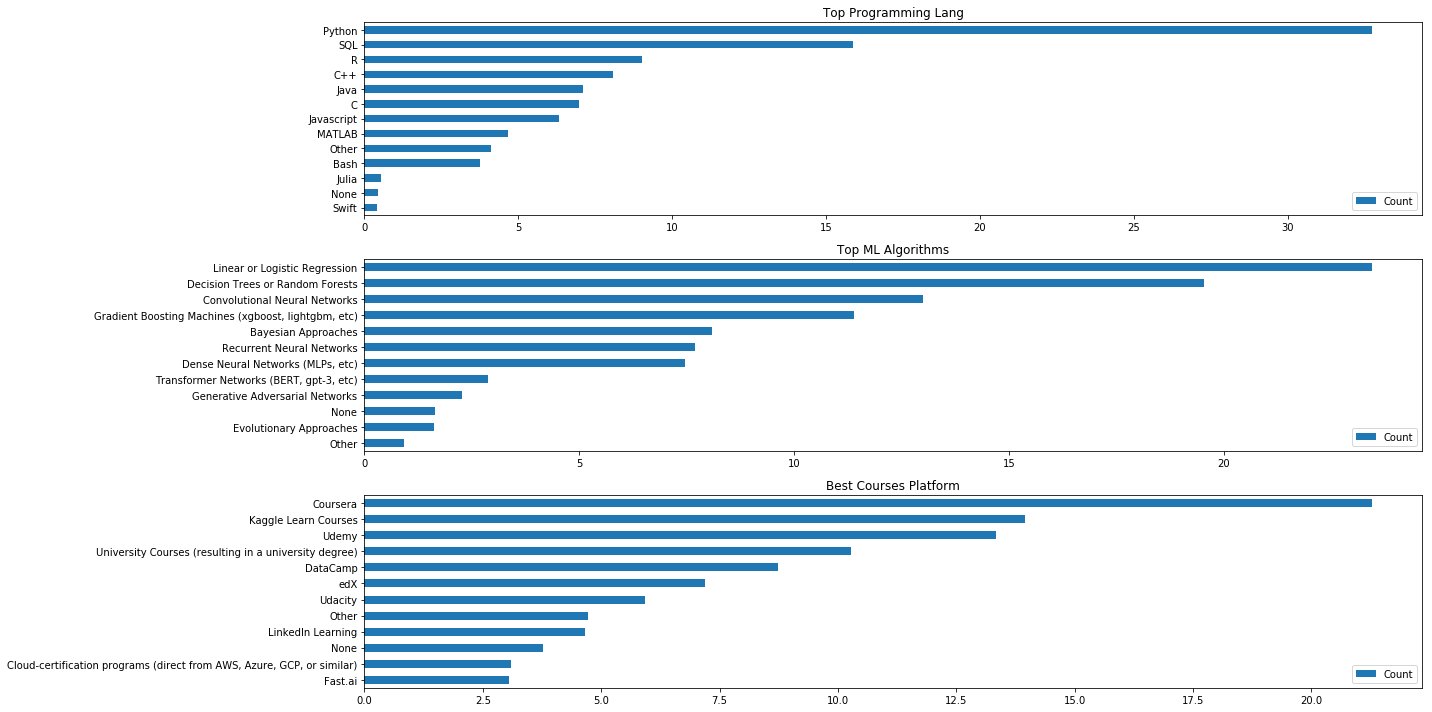

In [18]:
# Part#2
# Draw Most important knowledge Neeed using Matplotlib 
# here we define Subplts to be of size 3X1 
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
#passing each table for drawing
ML_Algorithm.sort_values(by = 'Count').plot(kind='barh', ax=axes[1] , title = 'Top ML Algorithms')
Prog_lang.sort_values(by = 'Count').plot(kind='barh', ax=axes[0] , title = 'Top Programming Lang')
Courses_Platform.sort_values(by = 'Count').plot(kind='barh', ax=axes[2] , title = 'Best Courses Platform')
plt.tight_layout()
plt.show()

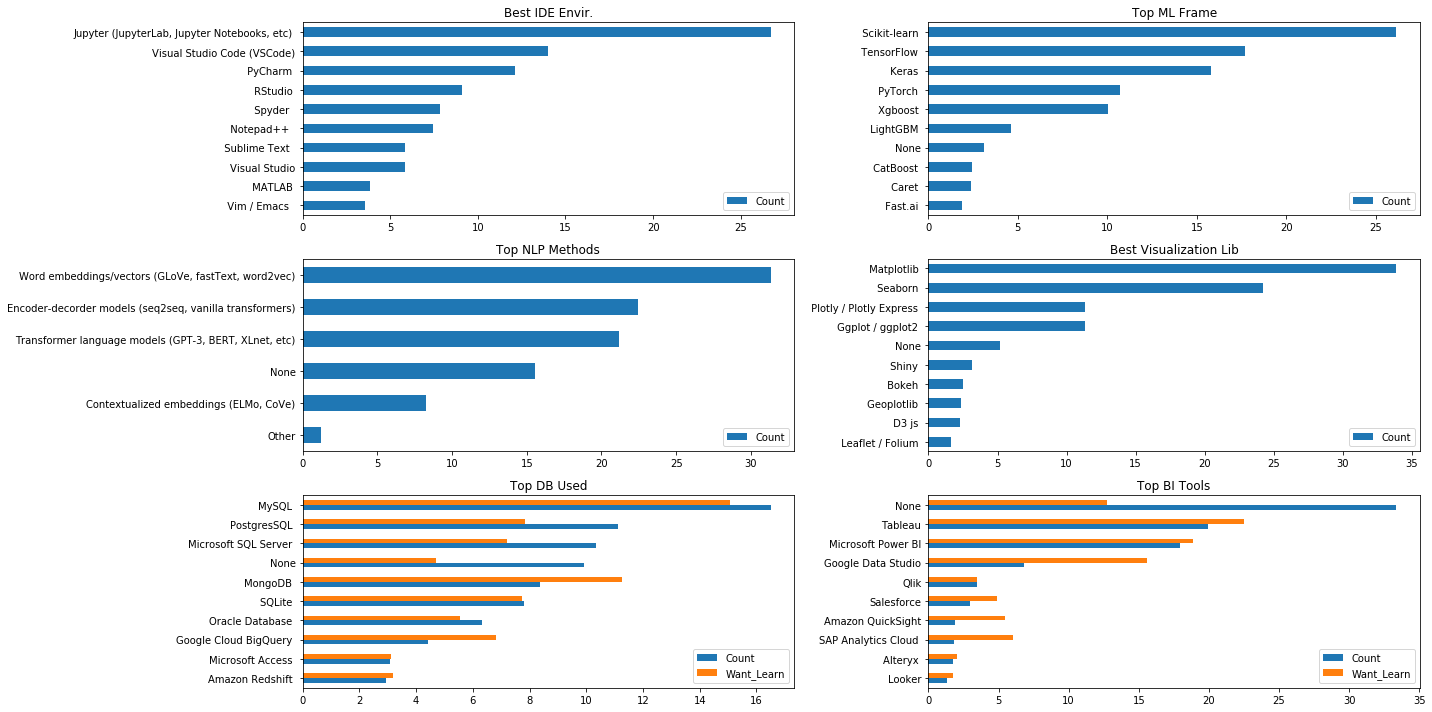

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

IDE_Develop_Envir[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[0,0] , title = 'Best IDE Envir.')
ML_Frame[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[0,1] , title = 'Top ML Frame')
NLP_Method[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[1,0] , title = 'Top NLP Methods')
BI_Tools[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[2,1] , title = 'Top BI Tools')
DB[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[2,0] , title = 'Top DB Used')
Visualization_Lib[:10].sort_values(by = 'Count').plot(kind='barh', ax=axes[1,1] , title = 'Best Visualization Lib')
plt.tight_layout()
plt.show()

# Second Business Question:
## Let's Try to predict Best job Title based on your Skills

### First let's correlate Job Title with Role at Work

CRISP-DM process for Q2:
1. Business & Data Understanding: From our dataframe we defined that It'll be useful to get more insights about relation between Job Title and different Job Rules.
2. Preparing Data: Split our original DF into smaller ones each contain one Job Title Only "Part#1" in below Code.
    Also, Split our Smaller DFs per gender to get Extra Insight from It.
3. Data Modeling: Modeling will start with concatenation for each job Title/Gender. 
4. Evaluate the Results: Evaluationg Data with our Visualization for Heat Map and Scatter Plot.


In [20]:
# Part#1
# Let's Split our original DF into smaller ones each contain one Job Title Only
df_Data_Engineer = df_mod[df_mod['Q5'] == 'Data Engineer']
df_Software_Engineer = df_mod[df_mod['Q5'] == 'Software Engineer']
df_Data_Scientist = df_mod[df_mod['Q5'] == 'Data Scientist' ]
df_Data_Analyst = df_mod[df_mod['Q5'] == 'Data Analyst']
df_Research_Scientist = df_mod[df_mod['Q5'] == 'Research Scientist']
df_Statistician = df_mod[df_mod['Q5'] == 'Statistician']
df_Product_Project_Manager = df_mod[df_mod['Q5'] == 'Product/Project Manager' ]
df_ML_Engineer = df_mod[df_mod['Q5'] == 'Machine Learning Engineer']
df_Business_Analyst = df_mod[df_mod['Q5'] == 'Business Analyst']
df_Database_Engineer = df_mod[df_mod['Q5'] == 'DBA/Database Engineer']

### Second let's correlate Job Title with Role at Work per Gender
### Split Splitted Data frames (Per Job Rule) to be Per Job Rule Per Gender 

In [21]:
# Split Diff Job titles DF into Men and Women DFs
df_Data_Engineer_Man = df_Data_Engineer[df_Data_Engineer['Q2'] == 'Man']
df_Software_Engineer_Man = df_Software_Engineer[df_Software_Engineer['Q2'] == 'Man']
df_Data_Scientist_Man = df_Data_Scientist[df_Data_Scientist['Q2'] == 'Man']
df_Data_Analyst_Man = df_Data_Analyst[df_Data_Analyst['Q2'] == 'Man']
df_Research_Scientist_Man = df_Research_Scientist[df_Research_Scientist['Q2'] == 'Man']
df_Statistician_Man = df_Statistician[df_Statistician['Q2'] == 'Man']
df_Product_Project_Manager_Man = df_Product_Project_Manager[df_Product_Project_Manager['Q2'] == 'Man']
df_ML_Engineer_Man = df_ML_Engineer[df_ML_Engineer['Q2'] == 'Man']
df_Business_Analyst_Man = df_Business_Analyst[df_Business_Analyst['Q2'] == 'Man']
df_Database_Engineer_Man = df_Database_Engineer[df_Database_Engineer['Q2'] == 'Man']

# For Woman
df_Data_Engineer_Woman = df_Data_Engineer[df_Data_Engineer['Q2'] == 'Woman']
df_Software_Engineer_Woman = df_Software_Engineer[df_Software_Engineer['Q2'] == 'Woman']
df_Data_Scientist_Woman = df_Data_Scientist[df_Data_Scientist['Q2'] == 'Woman']
df_Data_Analyst_Woman = df_Data_Analyst[df_Data_Analyst['Q2'] == 'Woman']
df_Research_Scientist_Woman = df_Research_Scientist[df_Research_Scientist['Q2'] == 'Woman']
df_Statistician_Woman = df_Statistician[df_Statistician['Q2'] == 'Woman']
df_Product_Project_Manager_Woman = df_Product_Project_Manager[df_Product_Project_Manager['Q2'] == 'Woman']
df_ML_Engineer_Woman = df_ML_Engineer[df_ML_Engineer['Q2'] == 'Woman']
df_Business_Analyst_Woman = df_Business_Analyst[df_Business_Analyst['Q2'] == 'Woman']
df_Database_Engineer_Woman = df_Database_Engineer[df_Database_Engineer['Q2'] == 'Woman']


### Some dummy Functions Call to prepare our Data :)
#### Creating Multiple Pivots for each Job Title 

In [22]:
## Count of Role at Work per Sex (Man , Woman):
# Let's Define For Man
Man_role_atwork_df_Data_Engineer = Split_gen(df_Data_Engineer_Man  , 'Q23', Inc_b = False)
Man_role_atwork_df_Software_Engineer = Split_gen(df_Software_Engineer_Man  , 'Q23', Inc_b = False)
Man_role_atwork_df_Data_Scientist  = Split_gen(df_Data_Scientist_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_Data_Analyst  = Split_gen(df_Data_Analyst_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_Research_Scientist = Split_gen(df_Research_Scientist_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_Statistician  = Split_gen(df_Statistician_Man   , 'Q23', Inc_b = False)
Man_role_atwork_Pro_manger = Split_gen(df_Product_Project_Manager_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_ML_Engineer  = Split_gen(df_ML_Engineer_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_Business_Analyst  = Split_gen(df_Business_Analyst_Man   , 'Q23', Inc_b = False)
Man_role_atwork_df_Database_Engineer = Split_gen(df_Database_Engineer_Man   , 'Q23', Inc_b = False)

# Let's Define For Woman
Woman_role_atwork_df_Data_Engineer = Split_gen(df_Data_Engineer_Woman  , 'Q23', Inc_b = False)
Woman_role_atwork_df_Software_Engineer = Split_gen(df_Software_Engineer_Woman  , 'Q23', Inc_b = False)
Woman_role_atwork_df_Data_Scientist  = Split_gen(df_Data_Scientist_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_Data_Analyst  = Split_gen(df_Data_Analyst_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_Research_Scientist = Split_gen(df_Research_Scientist_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_Statistician  = Split_gen(df_Statistician_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_Pro_manger = Split_gen(df_Product_Project_Manager_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_ML_Engineer  = Split_gen(df_ML_Engineer_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_Business_Analyst  = Split_gen(df_Business_Analyst_Woman   , 'Q23', Inc_b = False)
Woman_role_atwork_df_Database_Engineer = Split_gen(df_Database_Engineer_Woman   , 'Q23', Inc_b = False)


In [23]:
## Percent of each Job Rule for Data_Engineer Title
ML_Frame_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q16', Inc_b = False)
ML_Algorithm_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q17', Inc_b = False)
NLP_Method_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q19', Inc_b = False)
BI_Tools_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q31', Inc_b = False)
DB_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q29', Inc_b = False)
Courses_Platform_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q37', Inc_b = False)
Prog_lang_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q9', Inc_b = False)
Visualization_Lib_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q14', Inc_b = False)
Count_role_atwork_df_Data_Engineer = Split_gen(df_Data_Engineer , 'Q23', Inc_b = False)

## Percent of each Job Rule for Software_Engineer  Title
ML_Frame_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q16', Inc_b = False)
ML_Algorithm_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q17', Inc_b = False)
NLP_Method_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q19', Inc_b = False)
BI_Tools_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q31', Inc_b = False)
DB_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q29', Inc_b = False)
Courses_Platform_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q37', Inc_b = False)
Prog_lang_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q9', Inc_b = False)
Visualization_Lib_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q14', Inc_b = False)
Count_role_atwork_df_Software_Engineer = Split_gen(df_Software_Engineer , 'Q23', Inc_b = False)

## Percent of each Job Rule for Data_Scientist  Title
ML_Frame_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q16', Inc_b = False)
ML_Algorithm_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q17', Inc_b = False)
NLP_Method_df_Data_Scientist = Split_gen(df_Data_Scientist  , 'Q19', Inc_b = False)
BI_Tools_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q31', Inc_b = False)
DB_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q29', Inc_b = False)
Courses_Platform_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q37', Inc_b = False)
Prog_lang_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q9', Inc_b = False)
Visualization_Lib_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q14', Inc_b = False)
Count_role_atwork_df_Data_Scientist  = Split_gen(df_Data_Scientist  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Data_Analyst  Title
ML_Frame_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q16', Inc_b = False)
ML_Algorithm_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q17', Inc_b = False)
NLP_Method_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q19', Inc_b = False)
BI_Tools_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q31', Inc_b = False)
DB_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q29', Inc_b = False)
Courses_Platform_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q37', Inc_b = False)
Prog_lang_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q9', Inc_b = False)
Visualization_Lib_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q14', Inc_b = False)
Count_role_atwork_df_Data_Analyst  = Split_gen(df_Data_Analyst  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Research_Scientist  Title
ML_Frame_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q16', Inc_b = False)
ML_Algorithm_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q17', Inc_b = False)
NLP_Method_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q19', Inc_b = False)
BI_Tools_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q31', Inc_b = False)
DB_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q29', Inc_b = False)
Courses_Platform_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q37', Inc_b = False)
Prog_lang_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q9', Inc_b = False)
Visualization_Lib_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q14', Inc_b = False)
Count_role_atwork_df_Research_Scientist = Split_gen(df_Research_Scientist  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Statistician  Title
ML_Frame_df_Statistician  = Split_gen(df_Statistician  , 'Q16', Inc_b = False)
ML_Algorithm_df_Statistician  = Split_gen(df_Statistician  , 'Q17', Inc_b = False)
NLP_Method_df_Statistician  = Split_gen(df_Statistician  , 'Q19', Inc_b = False)
BI_Tools_df_Statistician  = Split_gen(df_Statistician  , 'Q31', Inc_b = False)
DB_df_Statistician  = Split_gen(df_Statistician  , 'Q29', Inc_b = False)
Courses_Platform_df_Statistician  = Split_gen(df_Statistician  , 'Q37', Inc_b = False)
Prog_lang_df_Statistician  = Split_gen(df_Statistician  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Statistician  = Split_gen(df_Statistician  , 'Q9', Inc_b = False)
Visualization_Lib_df_Statistician  = Split_gen(df_Statistician  , 'Q14', Inc_b = False)
Count_role_atwork_df_Statistician  = Split_gen(df_Statistician  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Pro_manger Title
ML_Frame_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q16', Inc_b = False)
ML_Algorithm_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q17', Inc_b = False)
NLP_Method_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q19', Inc_b = False)
BI_Tools_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q31', Inc_b = False)
DB_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q29', Inc_b = False)
Courses_Platform_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q37', Inc_b = False)
Prog_lang_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q7', Inc_b = False)
IDE_Develop_Envir_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q9', Inc_b = False)
Visualization_Lib_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q14', Inc_b = False)
Count_role_atwork_Pro_manger = Split_gen(df_Product_Project_Manager  , 'Q23', Inc_b = False)

## Percent of each Job Rule for ML_Engineer  Title
ML_Frame_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q16', Inc_b = False)
ML_Algorithm_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q17', Inc_b = False)
NLP_Method_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q19', Inc_b = False)
BI_Tools_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q31', Inc_b = False)
DB_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q29', Inc_b = False)
Courses_Platform_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q37', Inc_b = False)
Prog_lang_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q9', Inc_b = False)
Visualization_Lib_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q14', Inc_b = False)
Count_role_atwork_df_ML_Engineer  = Split_gen(df_ML_Engineer  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Business_Analyst  Title
ML_Frame_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q16', Inc_b = False)
ML_Algorithm_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q17', Inc_b = False)
NLP_Method_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q19', Inc_b =  False)
BI_Tools_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q31', Inc_b = False)
DB_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q29', Inc_b = False)
Courses_Platform_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q37', Inc_b = False)
Prog_lang_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q9', Inc_b = False)
Visualization_Lib_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q14', Inc_b = False)
Count_role_atwork_df_Business_Analyst  = Split_gen(df_Business_Analyst  , 'Q23', Inc_b = False)

## Percent of each Job Rule for Database_Engineer  Title
ML_Frame_df_Database_Engineer  = Split_gen(df_Database_Engineer  , 'Q16', Inc_b = False)
ML_Algorithm_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q17', Inc_b = False)
NLP_Method_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q19', Inc_b = False)
BI_Tools_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q31', Inc_b = False)
DB_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q29', Inc_b = False)
Courses_Platform_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q37', Inc_b = False)
Prog_lang_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q7', Inc_b = False)
IDE_Develop_Envir_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q9', Inc_b = False)
Visualization_Lib_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q14', Inc_b = False)
Count_role_atwork_df_Database_Engineer = Split_gen(df_Database_Engineer  , 'Q23', Inc_b = False)

In [24]:
# Part#2 
Role_at_Work = pd.concat([Count_role_atwork_df_Data_Engineer ,Count_role_atwork_df_Software_Engineer ,Count_role_atwork_df_Data_Scientist  ,
                 Count_role_atwork_df_Data_Analyst  , Count_role_atwork_df_Research_Scientist , Count_role_atwork_df_Statistician  , Count_role_atwork_Pro_manger , Count_role_atwork_df_ML_Engineer  , Count_role_atwork_df_Business_Analyst  , Count_role_atwork_df_Database_Engineer ],axis = 1,sort=True)

Woman_Role_at_Work = pd.concat([Woman_role_atwork_df_Data_Engineer ,Woman_role_atwork_df_Software_Engineer ,Woman_role_atwork_df_Data_Scientist  ,
                 Woman_role_atwork_df_Data_Analyst  , Woman_role_atwork_df_Research_Scientist , Woman_role_atwork_df_Statistician  , Woman_role_atwork_Pro_manger , Woman_role_atwork_df_ML_Engineer  , Woman_role_atwork_df_Business_Analyst  , Woman_role_atwork_df_Database_Engineer ],axis = 1,sort=True)

Man_Role_at_Work = pd.concat([Man_role_atwork_df_Data_Engineer ,Man_role_atwork_df_Software_Engineer ,Man_role_atwork_df_Data_Scientist  ,
                 Man_role_atwork_df_Data_Analyst  , Man_role_atwork_df_Research_Scientist , Man_role_atwork_df_Statistician  , Man_role_atwork_Pro_manger , Man_role_atwork_df_ML_Engineer  , Man_role_atwork_df_Business_Analyst  , Man_role_atwork_df_Database_Engineer ],axis = 1,sort=True)


In [25]:
Role_at_Work.columns = ['Data_Engineer','Software_Engineer','Data_Scientist','Data_Analyst','Research_Scientist','Statistician', 'Project_manger','ML_Engineer','Business_Analyst','Database_Engineer']
Man_Role_at_Work.columns = ['Data_Engineer','Software_Engineer','Data_Scientist','Data_Analyst','Research_Scientist','Statistician', 'Project_manger','ML_Engineer','Business_Analyst','Database_Engineer']
Woman_Role_at_Work.columns = ['Data_Engineer','Software_Engineer','Data_Scientist','Data_Analyst','Research_Scientist','Statistician', 'Project_manger','ML_Engineer','Business_Analyst','Database_Engineer']


In [ ]:
#Here, we'll draw Scatter Plot from Matplot lib. 
# First define Fig Size and Gidding Specs
fig = plt.figure(figsize=(20, 23), dpi=200)
gs = gridspec.GridSpec(5, 5)
ax_plot = fig.add_subplot(gs[1:4, 0:4])
# Outer Loop will loop over Job Titles and Inner Loop will loop over Job Rules
# Function inside loop is to get Man & Woman power for each Job Title and Job Rule
# Passing these values to Pie Drawer function to draw Scatter Plot 
for q5_idx in list(Role_at_Work.columns):
    for q23_idx in list(Role_at_Work.transpose().columns):
        man = Man_Role_at_Work[q5_idx][q23_idx]
        woman = Woman_Role_at_Work[q5_idx][q23_idx]
        tot = Role_at_Work[q5_idx][q23_idx]
        drawPieMarker([q5_idx],[q23_idx], [man/(man+woman), woman/(man+woman)] ,[tot*2.5], ['#004c70', '#990000'], ax=ax_plot)

#ax_plot.grid(linewidth=0.2, zorder=0)
ax_plot.set_yticklabels(list(Role_at_Work.transpose().columns), fontsize=3)
ax_plot.set_xticklabels(list(Role_at_Work.columns), fontfamily='serif', fontsize=5, rotation=90)

fig.text(0.8, 0.9, 'Job Title with Diff Role at Work Per Gender', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')
fig.text(0.8, 0.86, 'Red Color for Women & Blue For Men', fontweight='light', fontfamily='serif', fontsize=10, ha='right')
fig.text(0.8, 0.82, 'Pie Size represent Percent of Daily work for that Role', fontweight='light', fontfamily='serif', fontsize=10, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# Exp
#ax_exp = fig.add_subplot(gs[1:4, 4], sharey=ax_plot)
#data_q23_man = Sex_man.groupby(['Q23'])['Q6'].mean().dropna().sort_values(ascending = False)
#data_q23_woman = Sex_woman.groupby(['Q23'])['Q6'].mean().dropna().sort_values(ascending = False)

#data_q5_woman = data[data['Q2']=='Woman']['Q5'].value_counts()[q5_order]
#ax_exp.barh(data_q23_woman.index[::-1], data_q23_woman[::-1], height=0.55, alpha=0.7, color='#990000')

#data_q5_man = data[data['Q2']=='Man']['Q5'].value_counts()[q5_order]
#ax_exp.barh(data_q23_man.index[::-1], data_q23_man[::-1], left= data_q23_woman[::-1],height=0.55, alpha=0.7, color='#004c70')

#plt.setp(ax_exp.get_yticklabels(), visible=False)

# Spines
#for s in ['top', 'left', 'right', 'bottom']:
#    ax_plot.spines[s].set_visible(False)
 #   ax_pos.spines[s].set_visible(False)
 #   ax_exp.spines[s].set_visible(False)

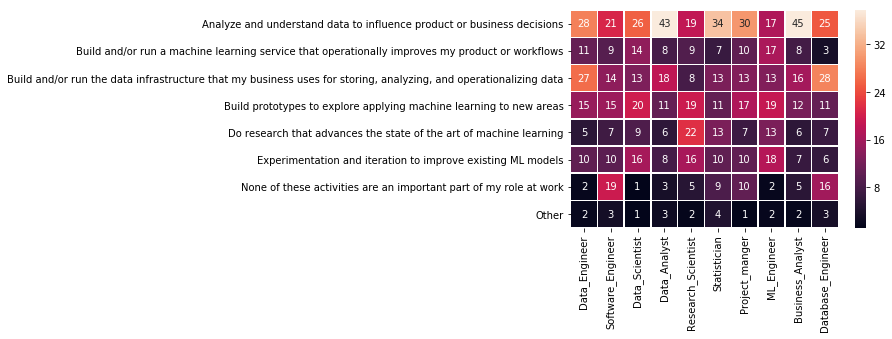

In [26]:
# Here we draw Heat Map for Job Titles with Job Rules 
Role_at_Work_tran = Role_at_Work.transpose()
sns.heatmap(Role_at_Work,annot =True, fmt = '.0f',linewidths=.5,robust = True)

## Now Let's Predict Job Title from Most Related Columns

### First: Let's Convert categorical Job Title Into Numeric to Use Linear Regression

This Model for predicting Job Title from other columns with Linear Regreesion but due to Final acuuracy which was 25% it wasn't
    included in final output.

In [28]:
df_mod_Position = df_mod_Pos(df_mod)
df_mod_Position.head(10)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_OTHER,ML_Frames_Count,ML_Algorithm_Count,NLP_Method_Count,BI_Tools_Count,DataBases_Count,Prog_lang_Count,IDEs_Count,Vis_lib_Count,Count_role_atwork
0,1838,35-39,Man,Colombia,Doctoral degree,0.0,5-10 years,Python,R,SQL,...,NaN,3.0,6.0,3.0,5.0,5.0,7.0,3.0,2.0,0.0
1,289287,30-34,Man,United States of America,Master’s degree,1.0,5-10 years,Python,R,SQL,...,NaN,4.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,2.0
2,860,35-39,Man,Argentina,Bachelor’s degree,2.0,10-20 years,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,2.0,3.0,3.0,4.0,1.0,1.0
3,507,30-34,Man,United States of America,Master’s degree,3.0,5-10 years,Python,NaN,SQL,...,NaN,4.0,5.0,0.0,1.0,2.0,3.0,1.0,3.0,3.0
4,78,30-34,Man,Japan,Master’s degree,2.0,3-5 years,Python,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,401,30-34,Man,India,Bachelor’s degree,4.0,< 1 years,Python,R,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0
6,748,22-24,Man,Brazil,Bachelor’s degree,0.0,3-5 years,Python,R,NaN,...,NaN,5.0,4.0,0.0,3.0,5.0,3.0,2.0,3.0,0.0
7,171196,25-29,Woman,China,Master’s degree,0.0,< 1 years,NaN,R,NaN,...,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
8,762,35-39,Man,Germany,Doctoral degree,3.0,5-10 years,Python,NaN,SQL,...,NaN,5.0,2.0,0.0,1.0,3.0,3.0,4.0,4.0,3.0
9,150,22-24,Man,China,No formal education past high school,0.0,< 1 years,Python,NaN,SQL,...,NaN,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


In [29]:
df_Jobs = df_mod_Position[['Q39_OTHER','Q39_Part_11','Q39_Part_10','Q39_Part_9','Q39_Part_8','Q39_Part_7','Q39_Part_6','Q39_Part_5','Q39_Part_4','Q39_Part_3','Q39_Part_2','Q39_Part_1','Q36_OTHER','Q36_Part_9','Q36_Part_8','Q36_Part_7','Q36_Part_6','Q36_Part_5','Q36_Part_4','Q36_Part_3','Q36_Part_2','Q36_Part_1','Q35_A_OTHER','Q35_A_Part_10','Q35_A_Part_9','Q35_A_Part_8','Q35_A_Part_7','Q35_A_Part_6','Q35_A_Part_5','Q35_A_Part_4','Q35_A_Part_3','Q35_A_Part_2','Q35_A_Part_1','Q34_A_OTHER','Q34_A_Part_11','Q34_A_Part_10','Q34_A_Part_9','Q34_A_Part_8','Q34_A_Part_7','Q34_A_Part_6','Q34_A_Part_5','Q34_A_Part_4','Q34_A_Part_3','Q34_A_Part_2','Q34_A_Part_1','Q33_A_OTHER','Q33_A_Part_7','Q33_A_Part_6','Q33_A_Part_5','Q33_A_Part_4','Q33_A_Part_3','Q33_A_Part_2','Q33_A_Part_1','Q32','Q31_A_OTHER','Q31_A_Part_14','Q31_A_Part_13','Q31_A_Part_12','Q31_A_Part_11','Q31_A_Part_10','Q31_A_Part_9','Q31_A_Part_8','Q31_A_Part_7','Q31_A_Part_6','Q31_A_Part_5','Q31_A_Part_4','Q31_A_Part_3','Q31_A_Part_2','Q31_A_Part_1','Q30','Q29_A_OTHER','Q29_A_Part_17','Q29_A_Part_16','Q29_A_Part_15','Q29_A_Part_14','Q29_A_Part_13','Q29_A_Part_12','Q29_A_Part_11','Q29_A_Part_10','Q29_A_Part_9','Q29_A_Part_8','Q29_A_Part_7','Q29_A_Part_6','Q29_A_Part_5','Q29_A_Part_4','Q29_A_Part_3','Q29_A_Part_2','Q29_A_Part_1','Q28_A_OTHER','Q28_A_Part_10','Q28_A_Part_9','Q28_A_Part_8','Q28_A_Part_7','Q28_A_Part_6','Q28_A_Part_5','Q28_A_Part_4','Q28_A_Part_3','Q28_A_Part_2','Q28_A_Part_1','Q27_A_OTHER','Q27_A_Part_11','Q27_A_Part_10','Q27_A_Part_9','Q27_A_Part_8','Q27_A_Part_7','Q27_A_Part_6','Q27_A_Part_5','Q27_A_Part_4','Q27_A_Part_3','Q27_A_Part_2','Q27_A_Part_1','Q26_A_OTHER','Q26_A_Part_11','Q26_A_Part_10','Q26_A_Part_9','Q26_A_Part_8','Q26_A_Part_7','Q26_A_Part_6','Q26_A_Part_5','Q26_A_Part_4','Q26_A_Part_3','Q26_A_Part_2','Q26_A_Part_1','Q23_OTHER','Q23_Part_7','Q23_Part_6','Q23_Part_5','Q23_Part_4','Q23_Part_3','Q23_Part_2','Q23_Part_1','Q22','Q21','Q19_OTHER','Q19_Part_5','Q19_Part_4','Q19_Part_3','Q19_Part_2','Q19_Part_1','Q18_OTHER','Q18_Part_6','Q18_Part_5','Q18_Part_4','Q18_Part_3','Q18_Part_2','Q18_Part_1','Q17_OTHER','Q17_Part_11','Q17_Part_10','Q17_Part_9','Q17_Part_8','Q17_Part_7','Q17_Part_6','Q17_Part_5','Q17_Part_4','Q17_Part_3','Q17_Part_2','Q17_Part_1','Q16_OTHER','Q16_Part_15','Q16_Part_14','Q16_Part_13','Q16_Part_12','Q16_Part_11','Q16_Part_10','Q16_Part_9','Q16_Part_8','Q16_Part_7','Q16_Part_6','Q16_Part_5','Q16_Part_4','Q16_Part_3','Q16_Part_2','Q16_Part_1','Q15','Q14_OTHER','Q14_Part_11','Q14_Part_10','Q14_Part_9','Q14_Part_8','Q14_Part_7','Q14_Part_6','Q14_Part_5','Q14_Part_4','Q14_Part_3','Q14_Part_2','Q14_Part_1','Q11','Q9_OTHER','Q9_Part_11','Q9_Part_10','Q9_Part_9','Q9_Part_8','Q9_Part_7','Q9_Part_6','Q9_Part_5','Q9_Part_4','Q9_Part_3','Q9_Part_2','Q9_Part_1','Q8','Q7_OTHER','Q7_Part_12','Q7_Part_11','Q7_Part_10','Q7_Part_9','Q7_Part_8','Q7_Part_7','Q7_Part_6','Q7_Part_5','Q7_Part_4','Q7_Part_3','Q7_Part_2','Q7_Part_1','Q6','Q5','Q4','Q1']]
df_Jobs_2 = df_mod_Position[['Q5','ML_Frames_Count', 'ML_Algorithm_Count',
       'NLP_Method_Count', 'BI_Tools_Count', 'DataBases_Count',
       'Prog_lang_Count', 'IDEs_Count', 'Vis_lib_Count', 'Count_role_atwork','Q23_OTHER','Q23_Part_7','Q23_Part_6','Q23_Part_5','Q23_Part_4','Q23_Part_3','Q23_Part_2','Q23_Part_1']]

In [29]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_mod_Position, 'Q5', dummy_na = False)

print("Train Score: ",train_score," & Test Score: ",test_score)

Train Score:  0.227391608409  & Test Score:  0.213823809569


In [30]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df[:10]

,est_int,coefs,abs_coefs
17,Q1_60-69,4.741473,4.741473
16,Q1_55-59,4.574887,4.574887
15,Q1_50-54,4.360968,4.360968
18,Q1_70+,4.316941,4.316941
14,Q1_45-49,4.268044,4.268044
13,Q1_40-44,3.871244,3.871244
12,Q1_35-39,3.625045,3.625045
11,Q1_30-34,3.340374,3.340374
10,Q1_25-29,2.833304,2.833304
9,Q1_22-24,1.677083,1.677083


# Third Business Question:
## Let's Know What's Affect The Salary

CRISP-DM process for Q3:
1. Business & Data Understanding: From our dataframe we defined that It'll be useful to get more insights related to Salary.
2. Preparing Data: First, Shrinking Salary ranges by modifying original DF.
    then Corelate Salary and Count of Used Tools and Frames "# Part#1"
3. Data Modeling: Modeling will start with # Here add New Column indicate Higher Ed with 0 & 1 
    Then Split our DF into 2 DFs one for Higher Ed and other for Normal Ed. 
4. Evaluate the Results: Evaluationg Data with our Visualization for Diff between Salary of Hier Ed and Normal Ed..


In [31]:
# Part#1
# Let's Shrink Salary Ranges to Visualize It Easily
df_mod_Salary = df_mod_Sal(df_mod)

### Let's Corelate Salary Ranges with Count of Used Tools and Frames

In [32]:
#Let's Corelate Salary and Count of Used Tools and Frames
Sal_MLFrames = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['ML_Frames_Count'].mean().sort_values(ascending=False))
Sal_MLAlg = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['ML_Algorithm_Count'].mean().sort_values(ascending=False))
Sal_NLP = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['NLP_Method_Count'].mean().sort_values(ascending=False))
Sal_BI= pd.DataFrame(df_mod_Salary.groupby(['Q24'])['BI_Tools_Count'].mean().sort_values(ascending=False))
Sal_DBs = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['DataBases_Count'].mean().sort_values(ascending=False))
Sal_Prog = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['Prog_lang_Count'].mean().sort_values(ascending=False))
Sal_IDEs = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['IDEs_Count'].mean().sort_values(ascending=False))
Sal_Visual = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['Vis_lib_Count'].mean().sort_values(ascending=False))
Sal_RoleAtWork = pd.DataFrame(df_mod_Salary.groupby(['Q24'])['Count_role_atwork'].mean().sort_values(ascending=False))

In [33]:
XYZ = pd.concat([Sal_MLFrames,Sal_MLAlg,Sal_NLP,Sal_BI,Sal_DBs,Sal_Prog,Sal_IDEs,Sal_Visual,Sal_RoleAtWork],axis = 1,sort=True)

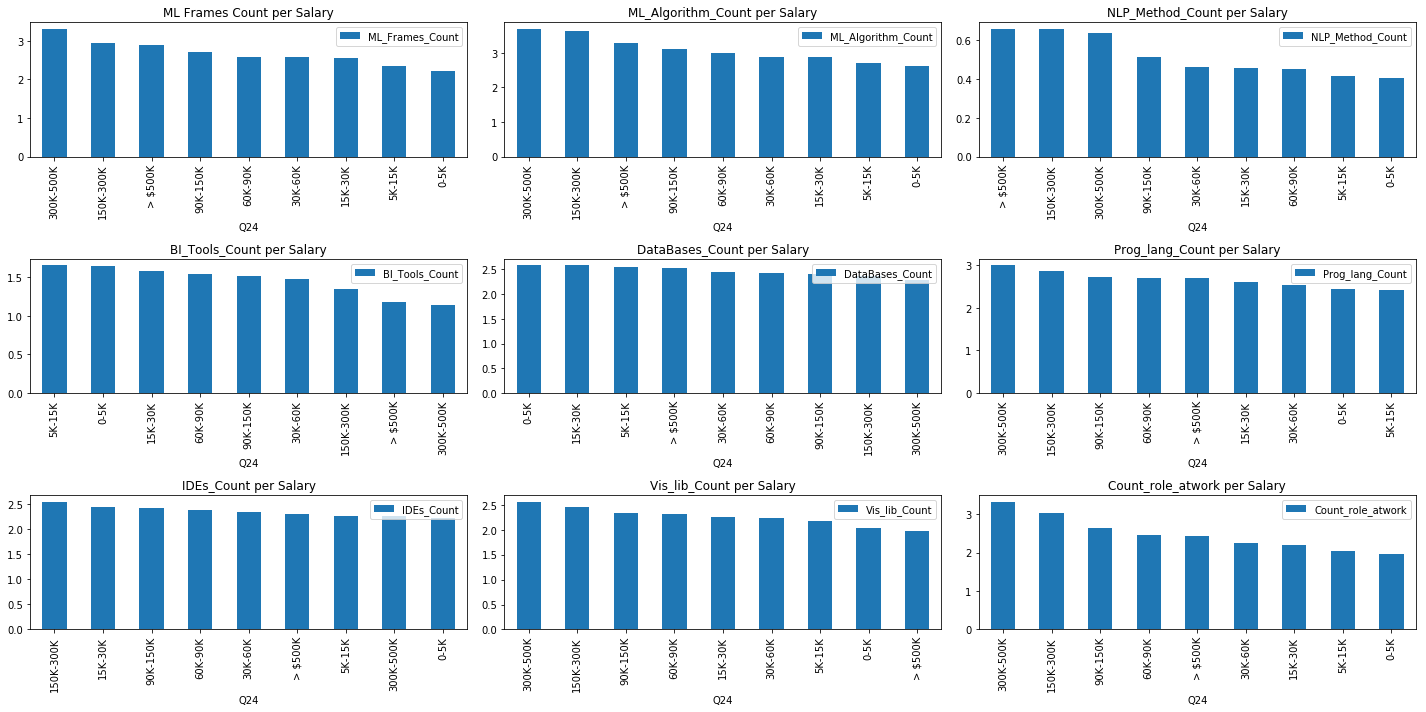

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

Sal_MLFrames.plot(kind='bar', ax=axes[0,0] , title = 'ML Frames Count per Salary')
Sal_MLAlg.plot(kind='bar', ax=axes[0,1] , title = 'ML_Algorithm_Count per Salary')
Sal_NLP.plot(kind='bar', ax=axes[0,2] , title = 'NLP_Method_Count per Salary')
Sal_BI.plot(kind='bar', ax=axes[1,0] , title = 'BI_Tools_Count per Salary')
Sal_DBs.plot(kind='bar', ax=axes[1,1] , title = 'DataBases_Count per Salary')
Sal_Prog.plot(kind='bar', ax=axes[1,2] , title = 'Prog_lang_Count per Salary')
Sal_IDEs.plot(kind='bar', ax=axes[2,0] , title = 'IDEs_Count per Salary')
Sal_Visual.plot(kind='bar', ax=axes[2,1] , title = 'Vis_lib_Count per Salary')
Sal_RoleAtWork.plot(kind='bar', ax=axes[2,2] , title = 'Count_role_atwork per Salary')
plt.tight_layout()
plt.show()

### Is Higher Formal Education Affect Salary Ranges ??

In [35]:
df_mod_Salary['Q4'].value_counts()

Master’s degree                                                      7859
Bachelor’s degree                                                    6978
Doctoral degree                                                      2302
Some college/university study without earning a bachelor’s degree    1092
Professional degree                                                   699
I prefer not to answer                                                399
No formal education past high school                                  240
Name: Q4, dtype: int64

In [36]:
def Higher_ed(Formal_ed):
    if Formal_ed in ('Master’s degree','Doctoral degree','Professional degree'):
        return 1
    else: return 0

In [37]:
# Here add New Column indicate Higher Ed with 0 & 1 
# Then Split our DF into 2 DFs one for Higher Ed and other for Normal Ed
df_mod_Salary['Higher_Edu'] = df_mod_Salary['Q4'].apply(Higher_ed)
ed_High = df_mod_Salary[df_mod_Salary['Higher_Edu'] == 1]
ed_Norm = df_mod_Salary[df_mod_Salary['Higher_Edu'] == 0]
# here we merge Value count percent for each DF to compare results
Comapr =pd.merge(pd.DataFrame(100*ed_High['Q24'].value_counts()/ed_High['Q24'].dropna().shape[0]),pd.DataFrame(100*ed_Norm['Q24'].value_counts()/ed_Norm['Q24'].dropna().shape[0]),left_index = True,right_index=True)

In [38]:
# rename Columns
Comapr.columns = ['Higher_Ed','Normal_Edu']
# adding Diff between Higher Ed and Normal Ed percent per Salary range 
Comapr['Edu_diff'] = Comapr['Higher_Ed'] - Comapr['Normal_Edu']
#Draw bar over Pivot indicating Diff Values
Comapr.style.bar(subset=['Edu_diff'],align='mid',color = ['#d65f5f','#5fba7d'])

,Higher_Ed,Normal_Edu,Edu_diff
0-5K,28.527,42.7635,-14.2366
30K-60K,16.2162,12.4522,3.764
5K-15K,13.089,16.3572,-3.26818
90K-150K,12.4664,7.83725,4.62915
60K-90K,11.5325,7.09995,4.43253
15K-30K,11.2636,10.0218,1.24177
150K-300K,5.80161,2.73075,3.07086
300K-500K,0.580161,0.382305,0.197857
> $500K,0.52356,0.354997,0.168563


### Let's Corelate Salary Ranges with Some Factors
### Extra un-fineshed work :(

In [39]:
df_selected = df_mod_Salary[['Q3','Q2','Q4','Q5','Q15','Q1','Q6','Q24']]
df_selected.dtypes

Q3     object
Q2     object
Q4     object
Q5     object
Q15    object
Q1     object
Q6     object
Q24    object
dtype: object

In [40]:
df_selected_dummy = Create_dummy_df(df_selected,df_selected.columns)

In [41]:
XYZ = df_selected_dummy.corr()

In [42]:
XYZ[['Q24_150K-300K','Q24_15K-30K','Q24_300K-500K','Q24_30K-60K','Q24_5K-15K','Q24_60K-90K', 'Q24_90K-150K', 'Q24_> $500K']].sort_values(by = ['Q24_300K-500K'],ascending=False).head(20)

,Q24_150K-300K,Q24_15K-30K,Q24_300K-500K,Q24_30K-60K,Q24_5K-15K,Q24_60K-90K,Q24_90K-150K,Q24_> $500K
Q24_300K-500K,-0.008479,-0.013024,1.000000,-0.015467,-0.015054,-0.012492,-0.013054,-0.002624
Q3_United States of America,0.293873,-0.063605,0.096500,-0.035562,-0.086774,0.085084,0.279750,0.020385
Q6_20+ years,0.173397,0.016174,0.055013,0.061920,-0.025789,0.078052,0.154526,0.038925
Q15_5-10 years,0.162743,0.019073,0.052593,0.065709,-0.018189,0.075778,0.132988,0.045962
Q15_10-20 years,0.091846,-0.000317,0.046358,0.022634,-0.011259,0.050302,0.098616,0.012688
Q15_20 or more years,0.131272,-0.000362,0.046334,0.013859,-0.008723,0.025258,0.054482,0.049059
Q6_10-20 years,0.093616,0.043355,0.044564,0.094480,-0.002791,0.124746,0.122892,0.023486
Q1_40-44,0.051563,0.031772,0.041819,0.072472,0.000547,0.073964,0.063200,0.021657
Q4_Doctoral degree,0.080893,0.027697,0.037933,0.062865,-0.010094,0.067714,0.076689,0.035307
Q5_Other,0.043680,0.047922,0.027906,0.055663,0.076863,0.043139,0.037656,0.009475
